# COMP7220/8220 Major Project.

## Load the test data

In [1]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt

%matplotlib inline

In [14]:
batch_size = 64
img_size = 112
fine_grain = True
num_classes = 50 if fine_grain else 8

root = Path('public')

Some potentially useful functions for reading data from files.

In [15]:
def load_target_names(path='public/info.json'):
    with open(path) as f:
        info = json.load(f)
    return info['fine'], info['coarse']

def load_image(file_path, image_size=112):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [image_size, image_size])
    return img

def create_dataset_tf(split, fine_grained, batch_size=32, image_size=112):
  df = pd.read_csv(root / f"{split}.csv")
  file_paths = df.filename.map(lambda fn: str(root / split / fn))
  labels = df.fine if fine_grained else df.coarse

  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  dataset = dataset.map(lambda x, y: (load_image(x, image_size=image_size), y))
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
  return dataset


def create_dataset_sklearn(split, fine_grained, image_size=48, percent=0.1):
  dataset = create_dataset_tf(split=split, fine_grained=fine_grained, batch_size=1000, image_size=image_size)
  dataset = dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
  X = None
  Y = None
  n_batches = int(len(dataset) * percent)
  for x,y in dataset.take(n_batches):
    x, y = x.numpy(), y.numpy()
    x = x.reshape(x.shape[0], -1)
    X = x if X is None else np.vstack([X, x])
    Y = y if Y is None else np.hstack([Y, y])

  return X, Y




In [4]:
fine_names, coarse_names = load_target_names()
print(coarse_names)

['Aves', 'Reptilia', 'Mammalia', 'Arachnida', 'Magnoliopsida', 'Insecta', 'Liliopsida', 'Pinopsida']


In [16]:
print(fine_names)

['Scolopacidae', 'Laridae', 'Accipitridae', 'Anatidae', 'Corvidae', 'Icteridae', 'Picidae', 'Colubridae', 'Sciuridae', 'Rosaceae', 'Cyperaceae', 'Brassicaceae', 'Sphingidae', 'Orchidaceae', 'Apidae', 'Papilionidae', 'Orobanchaceae', 'Liliaceae', 'Apocynaceae', 'Poaceae', 'Araneidae', 'Pinaceae', 'Asparagaceae', 'Acrididae', 'Hesperiidae', 'Rubiaceae', 'Onagraceae', 'Libellulidae', 'Fagaceae', 'Cactaceae', 'Lycaenidae', 'Coenagrionidae', 'Boraginaceae', 'Ranunculaceae', 'Polygonaceae', 'Pieridae', 'Caryophyllaceae', 'Lamiaceae', 'Noctuidae', 'Apiaceae', 'Malvaceae', 'Geometridae', 'Plantaginaceae', 'Euphorbiaceae', 'Crambidae', 'Parulidae', 'Erebidae', 'Ericaceae', 'Passerellidae', 'Tyrannidae']


Creating datatsets for sklearn (along with showing some images, so you can see what they're like).

In [20]:
X,Y = create_dataset_sklearn('train', fine_grained=fine_grain)

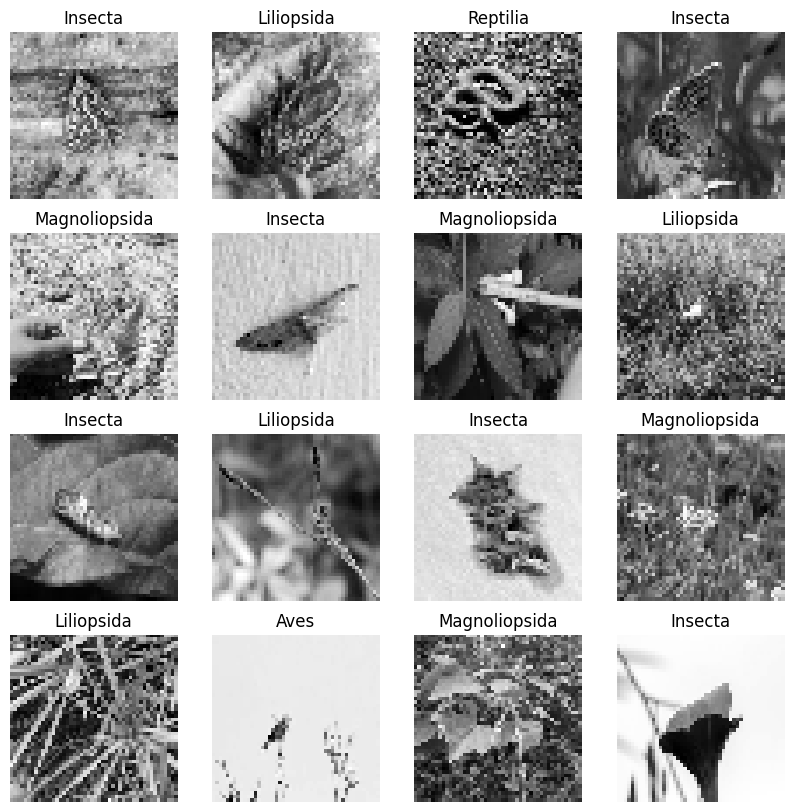

In [7]:
plt.figure(figsize=(10, 10))

for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(X[i].reshape(48,48), cmap='gray')
  if fine_grain:
    plt.title(fine_names[Y[i]])
  else:
    plt.title(coarse_names[Y[i]])
  plt.axis("off")
plt.show();

Creating datasets for TensorFlow.

In [21]:
train_ds = create_dataset_tf('train', fine_grained=fine_grain, batch_size=batch_size)
val_ds = create_dataset_tf('val', fine_grained=fine_grain, batch_size=batch_size)

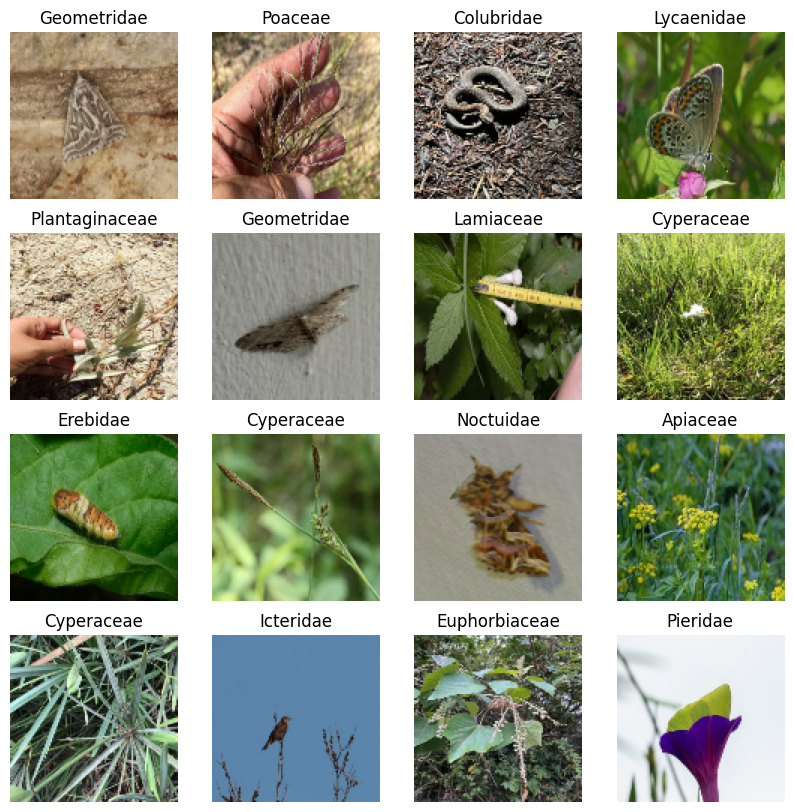

In [22]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy())
    if fine_grain:
      plt.title(fine_names[labels[i]])
    else:
      plt.title(coarse_names[labels[i]])
    plt.axis("off")
plt.show();

## Training an SVC model

In [12]:
from sklearn.svm import SVC

# Train a SVC model.
svm_clf = SVC(random_state=42)
svm_clf.fit(X, Y)

SVC(random_state=42)

Load the test data

In [8]:
# Choose one of these, depending on whether you're building sklearn or keras models
X_test, Y_test = create_dataset_sklearn('test', fine_grained=False, percent=1.0) # make sure to use all of the test set for sklearn
test_ds = create_dataset_tf('test', fine_grained=fine_grain, batch_size=batch_size)
X_val, Y_val = create_dataset_sklearn('val', fine_grained=False, percent=1.0)

In [14]:
svm_clf.score(X_val, Y_val)

0.46462

## SGD Classifier

In [20]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X=X, y=Y)

SGDClassifier()

In [21]:
sgd_clf.score(X_val, Y_val)

0.28028

In [22]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_val, Y_val, cv=3, scoring="accuracy")


array([0.26669467, 0.30143397, 0.31429257])

## Decision Tree Classifier

Training a decision tree instance

In [23]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X, Y)

DecisionTreeClassifier()

Compute the score on validating set

In [25]:
tree_clf.score(X_val, Y_val)

0.02158

## Voting Classifier

In [26]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression()),
        ('rf', RandomForestClassifier()),
        ('svc', SVC())
    ]
)
voting_clf.fit(X, Y)

/Users/dannguyen/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [27]:
voting_clf.score(X_val, Y_val)

0.07768

## AdaBoost Classifier


In [29]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(), n_estimators=30,
    learning_rate=0.5)
ada_clf.fit(X, Y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=0.5,
                   n_estimators=30)

In [30]:
ada_clf.score(X_val, Y_val)

0.30984

### Gradient Boosting Regressor


In [37]:
from sklearn.ensemble import GradientBoostingClassifier
gbrt_best = GradientBoostingClassifier()
gbrt_best.fit(X, Y)

KeyboardInterrupt: 

In [ ]:
gbrt_best.score(X_val, Y_val)

0.07377377403927032

## Stacking Classifier

In [34]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression()),
        ('rf', RandomForestClassifier()),
        ('svc', SVC(probability=True))
    ],
    final_estimator=RandomForestClassifier(),
    cv=5  # number of cross-validation folds
)
stacking_clf.fit(X, Y)

/Users/dannguyen/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dannguyen/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

KeyboardInterrupt: 

In [ ]:
stacking_clf.score(X_val, Y_val)

## Naive Bayes Classifier

In [35]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X, Y)

GaussianNB()

In [36]:
gnb.score(X_val, Y_val)

0.23182

Saving predictions to csv file for Kaggle.

In [28]:
# This is just making up a vector of predictions.  You should use the predictions of your models.
y_pred = voting_clf.predict(X_test)

In [ ]:
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"fine"] = y_pred
test_csv = test_csv.drop(columns=['coarse'])
pred_file = "46864660-conv-vot.csv"  # CHANGE DIRECTORY, FILENAME as appropriate
test_csv.to_csv(pred_file, index=False)